In [2]:
import tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tqdm import tqdm_notebook
from keras.layers import Dropout
from keras.utils import plot_model
from numpy.random import seed
from pylab import rcParams
import tensorflow 
import random
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV


N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=0.5               # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

fontsize = 14
ticklabelsize=14



#tensorflow.random.set_seed(1)
np.random.seed(1)
random.seed(1)

Using TensorFlow backend.


In [103]:
##data collection
import pandas_datareader as pdr
key="1dda9ab943a28e775931f1cffa8d2b66a28a5147"
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [104]:
df.to_csv('AAPL.csv')
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-08-10 00:00:00+00:00,119.72,119.99,116.53,116.53,54951597,110.823078,111.073013,107.870141,107.870141,54951597,0.0,1.0
1,AAPL,2015-08-11 00:00:00+00:00,113.49,118.18,113.33,117.81,97082814,105.056057,109.397522,104.907947,109.055019,97082814,0.0,1.0
2,AAPL,2015-08-12 00:00:00+00:00,115.24,115.42,109.63,112.53,101685610,106.676007,106.842630,101.482911,104.167399,101685610,0.0,1.0
3,AAPL,2015-08-13 00:00:00+00:00,115.15,116.40,114.54,116.04,48535789,106.592695,107.749802,106.028027,107.416555,48535789,0.0,1.0
4,AAPL,2015-08-14 00:00:00+00:00,115.96,116.31,114.01,114.32,42929516,107.342500,107.666490,105.537414,105.824376,42929516,0.0,1.0


In [105]:
df1=df.reset_index()['close']
df1

0       119.72
1       113.49
2       115.24
3       115.15
4       115.96
         ...  
1253    425.04
1254    435.75
1255    438.66
1256    440.25
1257    455.61
Name: close, Length: 1258, dtype: float64

Text(0, 0.5, 'close value')

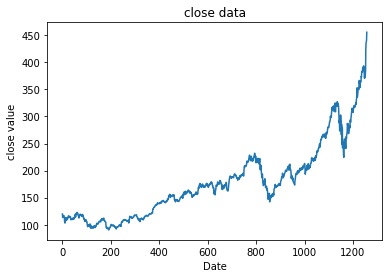

In [106]:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('close data')
plt.xlabel('Date')
plt.ylabel('close value')

In [107]:
df1=np.array(df1).reshape(-1,1)              

In [108]:
print(df1)

[[119.72]
 [113.49]
 [115.24]
 ...
 [438.66]
 [440.25]
 [455.61]]


In [109]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.60)
test_size=int(len(df1)*0.20)
cv_size=int(len(df1)*0.20)
train_data,cv_data,test_data=df1[0:training_size,:],df1[training_size:training_size+251,:1],df1[training_size+251:len(df1)-1,:1]

In [110]:
training_size,test_size,cv_size

(754, 251, 251)

In [111]:
type(train_data)

numpy.ndarray

In [112]:
test_data.shape

(252, 1)

In [113]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)    

In [114]:
time_step = N
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_cv,y_cv = create_dataset(cv_data, time_step)

In [115]:
print(X_train.shape), print(y_train.shape)

(744, 9)
(744,)


(None, None)

In [116]:
print(X_test.shape), print(y_test.shape)


(242, 9)
(242,)


(None, None)

In [117]:
print(X_cv.shape), print(y_cv.shape)

(241, 9)
(241,)


(None, None)

In [121]:
## scaling the data. Fit_transform in  test and cv but only transfrom in test
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_cv=scaler.transform(X_cv)
y_train=scaler.fit_transform(y_train.reshape(-1,1))
y_cv=scaler.transform(y_cv.reshape(-1,1))
y_test=scaler.transform(y_test.reshape(-1,1))


In [134]:
#Linear regression model
model=LinearRegression()
model.fit(X_train,y_train)
#prediction on cv set
predict=model.predict(X_test)
#print(predict)
predict=scaler.inverse_transform(predict.reshape(-1,1))
#print(predict)
y_test_unscaled=scaler.inverse_transform(y_test.reshape(-1,1))
#print(y_cv_unscaled)
rmse_lr= math.sqrt(mean_squared_error(y_test_unscaled, predict))
print(rmse_lr)

19.479839389305706


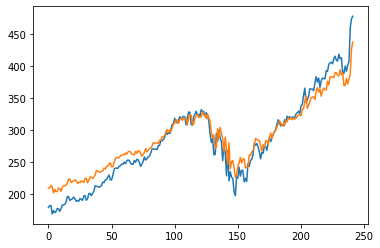

In [135]:
#graph showing linear regression results
plt.plot(y_test_unscaled)
plt.plot(predict)
plt.title('close data')
plt.xlabel('Date')
plt.ylabel('close value')

In [136]:
#KNN model
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(X_train,y_train)
preds = model.predict(X_test)
preds=scaler.inverse_transform(preds.reshape(-1,1))
rmse_knn= math.sqrt(mean_squared_error( mnk op0, preds))
print(rmse_knn)

109.26743469989165


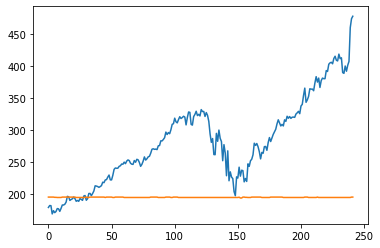

In [137]:
#graph showing KNN results
plt.plot(y_test_unscaled)
plt.plot(preds)
plt.title('close data')
plt.xlabel('Date')
plt.ylabel('close value')

In [59]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_cv =X_cv.reshape(X_cv.shape[0],X_cv.shape[1] , 1)

In [63]:
def train_pred_eval_model(X_train ,y_train,X_cv,y_cv,lstm_units=50,dropout_prob=0.5,optimizer='adam', epochs=1,
                          batch_size=1):
    
    
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        X_train  : e.g. x_train.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train  : e.g. y_train.shape=(451, 1)
        X_cv     : use this to do predictions 
        y_cv     : actual value of the predictions (scaled)
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
   
    #tensorflow.random.set_seed(1)

    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(dropout_prob))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = lstm_units, return_sequences = True))
    regressor.add(Dropout(dropout_prob))

    #regressor.add(LSTM(units = lstm_units, return_sequences = True))
    #regressor.add(Dropout(dropout_prob))
    
    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = lstm_units, return_sequences = True))
    regressor.add(Dropout(dropout_prob))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = lstm_units))
    regressor.add(Dropout(dropout_prob))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')

    # Compile and fit the LSTM network
 
    regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size,verbose=0)
    
    # Do prediction
    est_scaled = regressor.predict(X_cv)
    est = scaler.inverse_transform(est_scaled)

    # Get correct scale of y_cv
    y_cv = scaler.inverse_transform(y_cv.reshape(-1, 1))

    # Calculate RMSE and MAPE
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    

    return rmse, est, regressor

In [69]:
#initial model training
rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_test, y_test, lstm_units=lstm_units,dropout_prob=dropout_prob, optimizer='adam',epochs=epochs,batch_size=batch_size)
rsme_bef_tuning=rmse
print(rsme_bef_tuning)

52.977972690765995


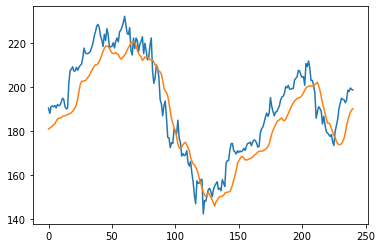

In [67]:
#graph showing KNN results
plt.plot(y_cv_unscaled)
plt.plot(est)

In [76]:
#Tuning N (no. of days to use as features)
param_label = 'N'
param_list = range(2, 50)

error_rate = {param_label: [], 'rmse': []}

for param in tqdm_notebook(param_list):
    
    
    # Split train into x and y
    X_train, y_train = create_dataset(train_data, time_step=param)
    
    

    # Split cv into x and y
    X_cv,y_cv = create_dataset(cv_data, time_step=param)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler(feature_range=(0,1))
    X_train=scaler.fit_transform(X_train)
    X_cv=scaler.transform(X_cv)
    y_tain=scaler.fit_transform(y_train)
    y_cv=scaler.transform(y_cv.reshape(-1,1))
    
    #y_test=scaler.transform(y_test.reshape(-1,1))
    
    
    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_cv =X_cv.reshape(X_cv.shape[0],X_cv.shape[1] , 1)
    
    # Train, predict and eval model
    rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_cv, y_cv, lstm_units=lstm_units,
                                 dropout_prob=dropout_prob, optimizer='adam',epochs=epochs,batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    
error_rate = pd.DataFrame(error_rate)
error_rate

c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


,N,rmse
0,2,7.340285
1,3,17.076319
2,4,6.718119
3,5,14.193964
4,6,13.882809
5,7,12.876825
6,8,9.242185
7,9,19.254983
8,10,17.061922
9,11,15.974584


Text(0, 0.5, 'RMSE/MAPE(%)')

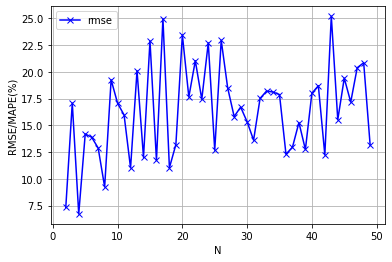

In [77]:
# Plot RMSE for N


ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [78]:
# Get optimum value for param N
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 6.718
optimum N = 4


In [79]:
#Tuning model - epochs and batch_size
param_label = 'epochs'
param_list = [1, 10,  50, 100,200,400]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128,256]

# Split train into x and y
X_train, y_train = create_dataset(train_data, time_step=N_opt)
    
# Split cv into x and y
X_cv,y_cv = create_dataset(cv_data, time_step=N_opt)

error_rate = {param_label: [], param2_label: [], 'rmse': []}
    
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_cv =X_cv.reshape(X_cv.shape[0],X_cv.shape[1] , 1)

for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_cv, y_cv, lstm_units=lstm_units,
                                 dropout_prob=dropout_prob, optimizer='adam',epochs=param,batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
    
error_rate = pd.DataFrame(error_rate)
error_rate

c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,epochs,batch_size,rmse
0,1,8,15.359268
1,1,16,34.220485
2,1,32,55.437678
3,1,64,58.579991
4,1,128,85.590128
5,1,256,95.860792
6,10,8,7.263097
7,10,16,11.376280
8,10,32,8.826465
9,10,64,6.187137


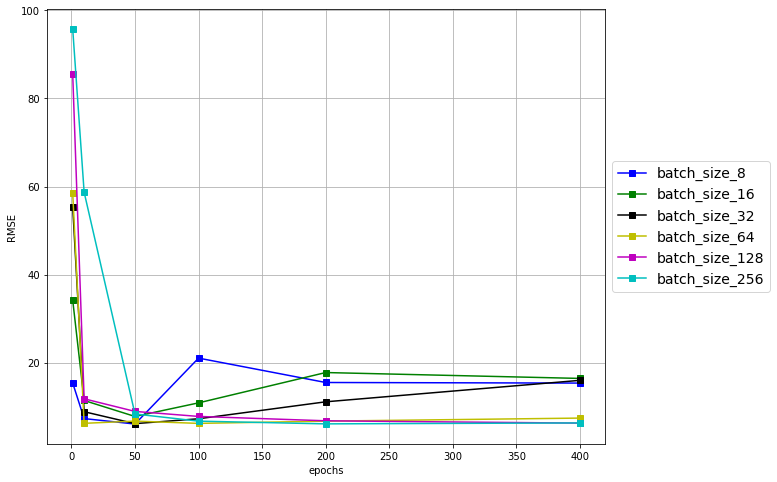

In [80]:
# Plot performance versus params epochs and batch size
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [81]:
# Get optimum value for epochs and batch size
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 6.027
optimum epochs = 50
optimum batch_size = 8


In [82]:
#Tuning model - LSTM units and dropout prob

param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9]

error_rate = {param_label: [], param2_label: [], 'rmse': []}

for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
        
    
        # Train, predict and eval model
        rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_cv, y_cv, lstm_units=param,
                                 dropout_prob=param2, optimizer='adam',epochs=epochs_opt,batch_size=batch_size_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        #error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate

c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


,lstm_units,dropout_prob,rmse
0,10,0.1,9.452836
1,10,0.2,12.483028
2,10,0.3,11.040854
3,10,0.4,11.140225
4,10,0.5,16.411128
5,10,0.6,17.348619
6,10,0.7,23.026507
7,10,0.8,30.339631
8,10,0.9,46.031243
9,50,0.1,4.941133


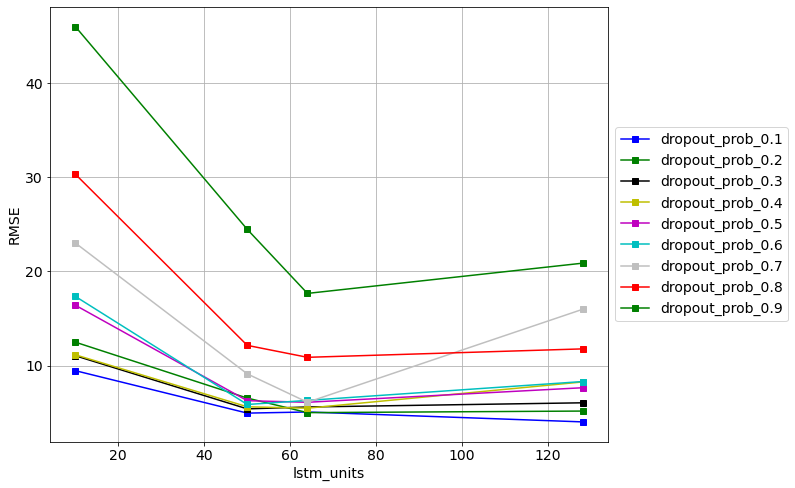

In [83]:
# Plot performance versus params dropout prob and lstm units
#rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [84]:
# Get optimum value for dropout prob and lstm units
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 4.007
optimum lstm_units = 128
optimum dropout_prob = 0.1


In [85]:
#Tuning model - optimizer

param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': []}
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_cv, y_cv, lstm_units=lstm_units_opt,
                                 dropout_prob=dropout_prob_opt, optimizer=param,epochs=epochs_opt,batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    #error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate

c:\users\admin\anaconda3\envs\gpuen\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


,optimizer,rmse
0,adam,4.064700
1,sgd,60.553611
2,rmsprop,12.602701
3,adagrad,6.340091
4,adadelta,75.048196
5,adamax,5.444632
6,nadam,4.189808


Text(0, 0.5, 'RMSE/MAPE(%)')

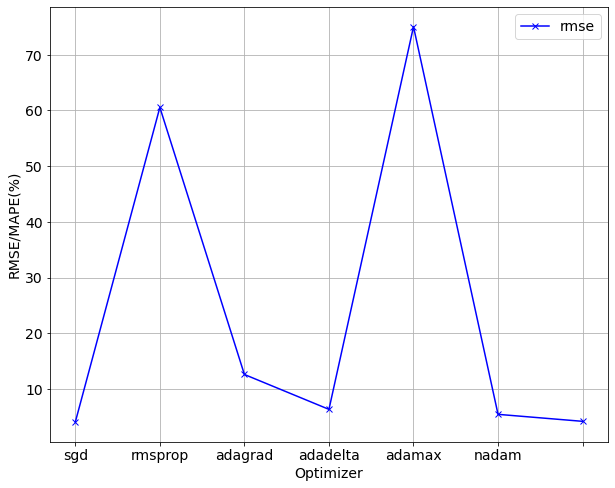

In [86]:
    # Plot RMSE for optimizer
    #rcParams['figure.figsize'] = 10, 8 # width 10, height 8

    ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
    #ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
    ax.set_xticklabels(param_list)
    ax.set_xlabel("Optimizer")
    ax.set_ylabel("RMSE/MAPE(%)")


In [87]:
# Get optimum value for optimizer
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
#print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 4.065
optimum optimizer = adam


In [88]:
#before tuning vs after tuning parameters
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rsme_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,4
1,lstm_units,50,128
2,dropout_prob,0.5,0.1
3,optimizer,adam,adam
4,epochs,1,50
5,batch_size,1,8
6,rmse,48.8947,4.0647


In [71]:
#Final model after tuning

#split train and test into X and y
X_train, y_train = create_dataset(train_data, time_step=N_opt)
X_test, y_test = create_dataset(test_data, time_step=N_opt)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
#X_cv=scaler.transform(X_cv)
#y_cv=scaler.fit_transform(y_cv.reshape(-1,1))
y_train=scaler.fit_transform(y_train.reshape(-1,1))
y_test=scaler.transform(y_test.reshape(-1,1))


# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Train, predict and eval model
rmse, est,regressor = train_pred_eval_model(X_train, y_train, X_test, y_test, lstm_units=lstm_units_opt,
                                 dropout_prob=dropout_prob_opt, optimizer=optimizer_opt,epochs=epochs_opt,batch_size=batch_size_opt)
print(rmse)

6.959103344360765


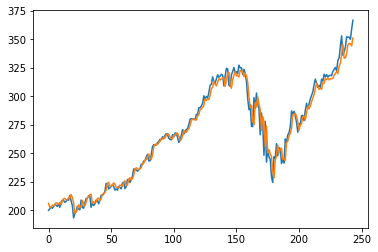

In [72]:
#final plotting original (test) data vs predicted data)
y_test=scaler.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_test)
plt.plot(est)
plt.title('close data')
plt.xlabel('Date')
plt.ylabel('close value')

In [73]:
result=pd.DataFrame(data=y_test,columns=['original'])
result['predicted']=est

In [74]:
result.head(10)

,original,predicted
0,200.02,205.961563
1,201.24,202.605286
2,203.23,202.710236
3,201.75,204.544342
4,203.30,203.924026
5,205.21,204.901337
6,204.50,206.563644
7,203.35,206.334717
8,205.66,205.357574
9,202.59,206.912430
